# Quantum Random Number Generator - Simulation


## DV QRNG

### Core Physics 
A **qubit** is a two level quantum system with states $|0\rangle$ and $|1\rangle$.

Canonical Textbook example:

If we prepare the qubit in the state $|0\rangle$ and apply a **Hadamard gate** $H$, the state becomes: $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$

If we now measure this state in the **computational basis** $\{ |0\rangle, |1\rangle \}$, the **Born rule** says:
$P(0) = |\langle 0 | + \rangle|^2 = \tfrac{1}{2}$ and $P(1) = |\langle 1 | + \rangle|^2 = \tfrac{1}{2}$

*Intrinsic* randomness of quantum mechanics vs deterministic classical randomness (chaos). 

Even if we had complete information about the system, the measurement outcome is **fundamentally unpredictable**.  
Each measurement therefore gives one *truly random bit*.

#### **Qiskit**
- IBM’s open-source Python framework for quantum computing
- allows the simulation of quantum circuits on a classical computer
- run the same circuits on **real IBM quantum processors** in the cloud

This means that:
- on a simulator, we get *simulated quantum statistics* (generated using a classical pseudo-random number generators)  
- on a real IBM quantum device, we can obtain *genuine quantum random numbers*

<!--
$\rightarrow$ i created an IBM Quantum account and i am trying to get cloud access to real quantum chips (working on it...)

<div class="alert alert-block alert-info">
<b>coming in the near future 👩🏻‍💻
</div>
-->


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
import scienceplots

plt.style.use('science')

In [12]:
qc = QuantumCircuit(1, 1)  
qc.h(0)  
qc.measure(0, 0)
#print(qc.draw())

backend = AerSimulator() 
transpiled_qc = transpile(qc, backend)
job = backend.run(transpiled_qc, shots=1000000, memory=True)
result = job.result()
bitstring = np.array(result.get_memory(), dtype=np.uint8)
print('Bitstring: ', bitstring)
print('First 100 bits of Bitstring: \n', bitstring[:100])

counts = result.get_counts()
print()
print('Random bits generated: ', counts)


Bitstring:  [1 0 1 ... 1 0 1]
First 100 bits of Bitstring: 
 [1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1
 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1]

Random bits generated:  {'0': 499476, '1': 500524}


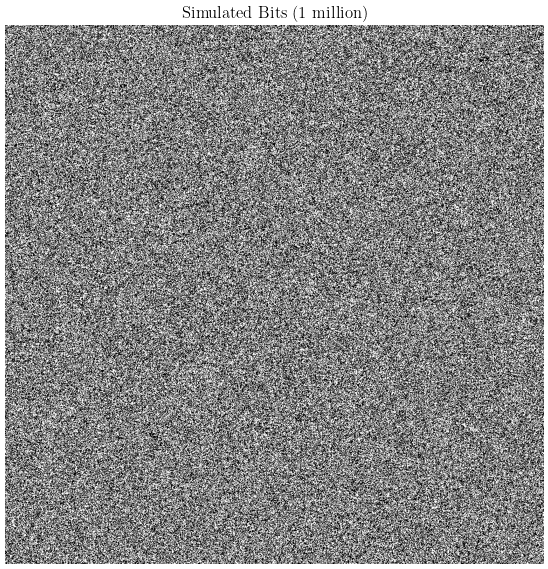

In [69]:
n_bits = len(bitstring)
size = int(np.ceil(np.sqrt(n_bits)))

padded_bits = np.pad(bitstring, (0, size**2 - n_bits), 'constant')
bit_array = padded_bits.reshape((size, size))

plt.figure(figsize=(7, 7))
plt.imshow(bit_array, cmap='gray_r')  # 0 = white, 1 = black
plt.axis('off')
plt.title('Simulated Bits (1 million)')
plt.savefig('simulated_bits.png')
plt.show()

#### **$H_{min}$ Min-Entropy**  

Min-entropy ($H_{min}$) is a measure of the unpredictability of a random variable. It is defined as: $H_{min}(X) = -log_2(max(P(X=x)))$

- $H_{min}(X) = 0$ $\rightarrow$ fully predictable
- $H_{min}(X) = 1$ $\rightarrow$ perfectly random (maximally unpredictable) ideal qrng with $p_0 \approx p_1 \approx 0.5$


Min Entropy:  0.9984888473029254


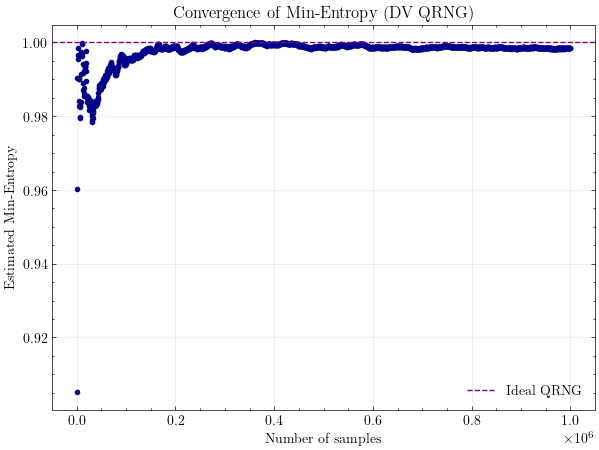

In [14]:
def min_entropy(bitstring):
    shots = len(bitstring)
    counts = np.bincount(bitstring, minlength=2)
    probs = counts / shots
    return -np.log2(np.max(probs))

h_min = min_entropy(bitstring)
print('Min Entropy: ', h_min)

# graph for how the estimated min-entropy converges as more bits are collected => whether bias stabilizes or not
window = 500  # checking min_entropy every 500 samples
H_vals = []
for i in range(window, len(bitstring), window):
    H_vals.append(min_entropy(bitstring[:i]))

plt.figure(figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(range(window, len(bitstring), window), H_vals, linestyle='None',marker='.', color='darkblue')
plt.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
plt.xlabel('Number of samples')
plt.ylabel('Estimated Min-Entropy')
plt.title('Convergence of Min-Entropy (DV QRNG)')
plt.legend()
plt.show()

#### **$H$ Shannon Entropy**  

Shannon entropy ($H$) measures the **average uncertainty** of a random variable. It is defined as: $H(X) = - \sum_{i} P(X=x_i) \log_2 P(X=x_i)$

- $H(X) = 0$ $\rightarrow$ fully predictable  
- $H(X) = 1$ $\rightarrow$ perfectly random (maximally unpredictable) for a binary variable with $p_0 \approx p_1 \approx 0.5$  

Shannon entropy takes into account the probabilities of all outcomes, providing a measure of **average randomness**, unlike min-entropy which only considers the most likely outcome.


In [15]:
def shannon_entropy(bits):
    counts = np.bincount(bits, minlength=2)
    probs = counts / len(bits)
    H = 0
    for p in probs:
        if p > 0:
            H -= p * np.log2(p)
    return H

h_shannon = shannon_entropy(bitstring)
print('Shannon Entropy: ', h_shannon)

Shannon Entropy:  0.9999992077409879


### **Randomness Extraction Models**

Randomness Extraction Models are methods / algorithms that take biased sources of randomness and produce uniform, unbiased random bits

- Von Neumann Extractor (pair-wise)
- Hash-based Extractor

#### Von Neumann Extractor

The **von Neumann extractor** is a simple method to *remove bias* from a random bit sequence. It works by reading the bits in **pairs** of two:
-  `00` or `11` $\rightarrow$ discard
-  `01` $\rightarrow$ output `0`
-  `10` $\rightarrow$ output `1`

$\Rightarrow$ more **uniformly random sequence**, even if the original source has a slight bias.


In [16]:
def von_neumann_extraction(bits):
    extracted_bits = []
    for i in range(0, len(bits)-1, 2):
        pair = bits[i], bits[i+1]
        if pair == (0, 1):
            extracted_bits.append(0)
        elif pair == (1, 0):
            extracted_bits.append(1)
    return np.array(extracted_bits, dtype=np.uint8)

vn_bits = von_neumann_extraction(bitstring)
print('Initial bitstring length: ', len(bitstring))
print('Extracted (Von Neumann) bitstring length: ', len(vn_bits))
percent_survived = (len(vn_bits) / len(bitstring)) * 100
print(f'Percentage of bits that survived: {percent_survived:.2f}%')

unique, counts_vn = np.unique(vn_bits, return_counts=True)
counts_dict = {int(k): int(v) for k, v in zip(unique, counts_vn)}
print()
print('Initial counts: ', counts)
print('Von Neumann counts: ', counts_dict)

shots_vn = len(vn_bits)
if shots_vn > 0:
    probs_vn = counts_vn / shots_vn
    h_min_vn = -np.log2(np.max(probs_vn))
    print()
    print('Initial Min Entropy: ', h_min)
    print('Min Entropy after Von Neumann extraction: ', h_min_vn)
else:
    print('No bits survived the Von Neumann extraction')


Initial bitstring length:  1000000
Extracted (Von Neumann) bitstring length:  249668
Percentage of bits that survived: 24.97%

Initial counts:  {'0': 499476, '1': 500524}
Von Neumann counts:  {0: 124782, 1: 124886}

Initial Min Entropy:  0.9984888473029254
Min Entropy after Von Neumann extraction:  0.9993991659201461


#### Von Neumann extraction:
- pros: nice & simple method 

- cons: discards a lotttt of bits (~75%) $\Rightarrow$ wastes data

     - computational cost (extra memory & CPU cycles)

    - time inefficiency 

### Hash-based Extraction 

Hash functions = math function / algorithm that maps input data of any size to a fixed-size string output
- cryptographic hash functions (SHA-256, SHA-3, Blake2, MD5) $\rightarrow$ less secure now


*Hash-based Randomness Extraction model* uses hash functions as extractors bc they:

- get a biased random input & they output a uniform(-ish?) bitstring 

- retain nearly all entropy from the input without discarding most bits (unlike Von Neumann)


In [17]:
import hashlib

def hash_extraction(bits, block_size=512, hash_func='sha256'):
    """
    Hash-based randomness extractor => using SHA-256
    
    bits: numpy array of 0/1 values
    block_size: number of input bits per block
    hash_func: cryptographic hash function (sha256, sha512, etc.)
    
    Returns: extracted bitstring as numpy array
    """
    extracted_bits = []
    hash_func_constructor = getattr(hashlib, hash_func)
    
    for i in range(0, len(bits), block_size):
        block = bits[i:i+block_size]
        if len(block) < block_size:
            break  # drop incomplete block
        byte_val = int("".join(map(str, block.tolist())), 2).to_bytes(block_size // 8, byteorder="big")
        digest = hash_func_constructor(byte_val).digest()
    
        digest_bits = np.unpackbits(np.frombuffer(digest, dtype=np.uint8))
        extracted_bits.extend(digest_bits)
    
    return np.array(extracted_bits, dtype=np.uint8)

hash_bits = hash_extraction(bitstring, block_size=512, hash_func='sha256')
print('Length of hash-extracted bits: ', len(hash_bits))
print('First 100 hash-extracted bits: \n', hash_bits[:100])


if len(hash_bits) > 0:
    h_min_hash = min_entropy(hash_bits)
    print()
    print('Initial Min Entropy: ', h_min)
    print('Min Entropy after Hash extraction: ', h_min_hash)
else:
    print('No bits were produced by the hash extractor.')



Length of hash-extracted bits:  499968
First 100 hash-extracted bits: 
 [1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1]

Initial Min Entropy:  0.9984888473029254
Min Entropy after Hash extraction:  0.9998326463709473


so far ideal simulator, thus $\Rightarrow$ simulating realistic quantum noise

### **Adding Noise** yay

*Qiskit's Noise Models* $\Rightarrow$ pre-defined noise models from *real IBM quantum devices* (+ custom) can simulate:

- gate errors (hadamard)

- readout / measurement errors 

- decoherence errors (T1/T2 relaxation) aka qubit loses its quantum information over time due to interactions with the environment
    - T1 relaxation (energy relaxation) $\rightarrow$ qubit loses energy to its environment (from $|0\rangle$ to $|1\rangle$)

        $\Rightarrow$ flips to $|0\rangle$ over time, thus: prob of remaining in $|1\rangle$ decreases as: $e^{-t/T_1}$
    
    - T2 relaxation (dephasing) (no energy change) $\rightarrow$ loss of phase information in a superposition
     
        $\Rightarrow$ qubit’s superposition collapses faster than intended, thus coherence decays as: $e^{-t/T_2}$

- thermal errors $\rightarrow$ could be added in every part of the circuit 

In [18]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

noise_model = NoiseModel()

gate_error = depolarizing_error(0.01, 1)  # applying a 1-qubit gate (Hadamard) => 1% chance that the qubit gets randomized
noise_model.add_all_qubit_quantum_error(gate_error, ['h'])

readout_error = ReadoutError([[0.90, 0.10], [0.03, 0.97]])  # confusion matrix => 90% for |0⟩ 10% for |1⟩, and 97% for |1⟩ 3% for |0⟩
noise_model.add_all_qubit_readout_error(readout_error)  # favouring the |0⟩ state

'''
# readout error just for dark counts, confusion matrix:
ReadoutError([[0.99, 0.01],  # true 0 (99%) => sometimes mistaken as 1 (dark count)
              [0.00, 1.00]]) # true 1 (100%) always read correctly
'''

backend_noisy = AerSimulator(noise_model=noise_model)
transpiled_qc_noisy = transpile(qc, backend_noisy)
job_noisy = backend_noisy.run(transpiled_qc_noisy, shots=100000, memory=True)
result_noisy = job_noisy.result()
bitstring_noisy = np.array(result_noisy.get_memory(), dtype=np.uint8)

print('Noisy bitstring sample: \n', bitstring_noisy[:100])

h_min_noisy = min_entropy(bitstring_noisy)
print()
print('Min Entropy (ideal system): ', min_entropy(bitstring))
print('Noisy Min Entropy: ', h_min_noisy)
h_shannon_noisy = shannon_entropy(bitstring_noisy)
print('Noisy Shannon Entropy: ', h_shannon_noisy)

Noisy bitstring sample: 
 [1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1]

Min Entropy (ideal system):  0.9984888473029254
Noisy Min Entropy:  0.9037651386822287
Noisy Shannon Entropy:  0.9965649279047488


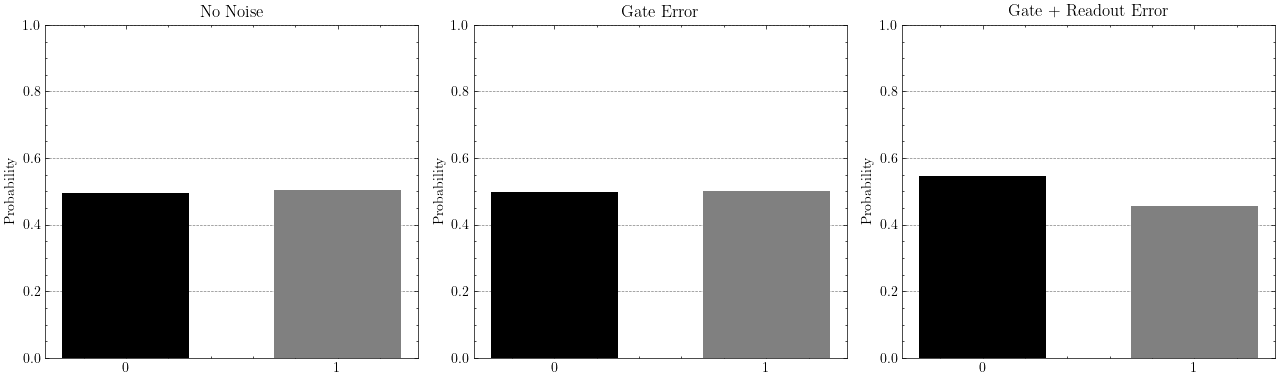

In [49]:
def run_qrng(noise_model=None, shots=10000):
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    
    backend = AerSimulator(noise_model=noise_model)
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots, memory=True)
    result = job.result()
    bits = np.array(result.get_memory(), dtype=np.uint8)
    
    return bits, result.get_counts()

no_noise = None

gate_error = depolarizing_error(0.05, 1)   # 5% depolarizing error on single qubit gates
noise_gate = NoiseModel()
noise_gate.add_all_qubit_quantum_error(gate_error, ['h'])

readout_error = ReadoutError([[0.9, 0.1],[0.2, 0.8]])
noise_gate_readout = NoiseModel()
noise_gate_readout.add_all_qubit_quantum_error(gate_error, ['h'])
noise_gate_readout.add_all_qubit_readout_error(readout_error, [0])

bits_no_noise, _ = run_qrng(noise_model=no_noise)
bits_gate, _ = run_qrng(noise_model=noise_gate)
bits_gate_readout, _ = run_qrng(noise_model=noise_gate_readout)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
titles = ['No Noise', 'Gate Error', 'Gate + Readout Error']
all_bits = [bits_no_noise, bits_gate, bits_gate_readout]

for ax, title, bits in zip(axes, titles, all_bits):
    counts = np.bincount(bits, minlength=2)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_axisbelow(True)
    ax.bar([0, 1], counts / counts.sum(), color=['black', 'gray'], width=0.6)
    ax.set_xticks([0, 1])
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()

$\Rightarrow$ seeing schematecally how *gate* errors affect the min-entropy value (with fixed and no readout errors) 

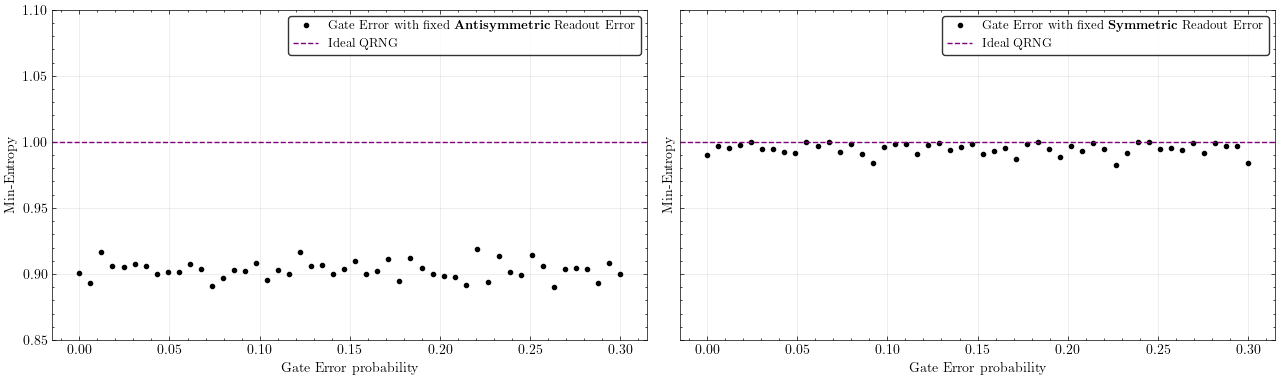

In [41]:
gate_probs = np.linspace(0, 0.3, 50)  # from 0% to 30%

readout_errors = {
    'Antisymmetric': ReadoutError([[0.90, 0.10],
                                   [0.03, 0.97]]),
    'Symmetric': ReadoutError([[0.90, 0.10],
                               [0.10, 0.90]])
}

entropies_results = {}
for name, readout_error in readout_errors.items():
    entropies_gate = []
    for p in gate_probs:
        noise_model = NoiseModel()
        gate_error = depolarizing_error(p, 1)
        noise_model.add_all_qubit_quantum_error(gate_error, ['h'])
        noise_model.add_all_qubit_readout_error(readout_error)

        backend_noisy = AerSimulator(noise_model=noise_model)
        transpiled_qc = transpile(qc, backend_noisy)
        result = backend_noisy.run(transpiled_qc, shots=50000, memory=True).result()
        bits = np.array(result.get_memory(), dtype=np.uint8)
        entropies_gate.append(min_entropy(bits))

    entropies_results[name] = entropies_gate

fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

for ax, (name, entropies) in zip(axes, entropies_results.items()):
    ax.plot(gate_probs, entropies, 'k.', label=fr'Gate Error with fixed \textbf{{{name}}} Readout Error')
    ax.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
    ax.set_ylim(0.85, 1.10)
    ax.set_xlabel('Gate Error probability')
    ax.set_ylabel('Min-Entropy')
    #ax.set_title(fr'Effect of Gate Error on Min-Entropy with \textbf{{{name}}} Readout Error')
    ax.legend(frameon=True, fancybox=True, edgecolor='black', facecolor='white', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### parallelism 

$\rightarrow$ the code above takes ~ 8s, so to make it faster i used **parallelism** with `joblib.Parallel` and `delayed`

$\rightarrow$ multiple simulations run simultaneously across all available CPU cores 

$\rightarrow$ reduced runtime to ~ 1.5s $\rightarrow$ achieved speedup of roughly 5×

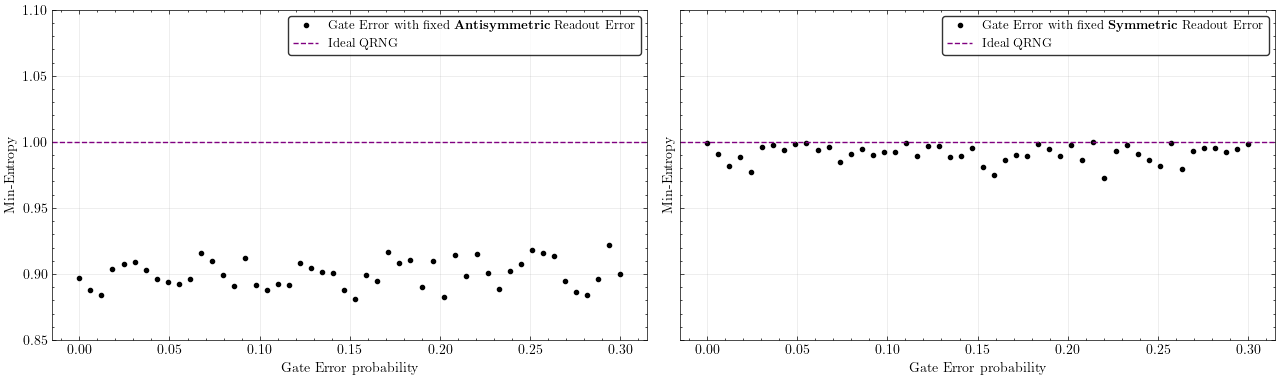

In [ ]:
from joblib import Parallel, delayed

gate_probs = np.linspace(0, 0.3, 50)  # 0% to 30% depolarizing error

readout_errors = {
    'Antisymmetric': ReadoutError([[0.90, 0.10],
                                   [0.03, 0.97]]),
    'Symmetric': ReadoutError([[0.90, 0.10],
                               [0.10, 0.90]])
}

def run_one(p, readout_error, shots=20000):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['h'])
    noise_model.add_all_qubit_readout_error(readout_error)
    
    result = backend.run(transpiled_qc, shots=shots, noise_model=noise_model, memory=True).result()
    bits = np.array(result.get_memory(), dtype=np.uint8)
    return min_entropy(bits)

entropies_results = {
    name: Parallel(n_jobs=-1)(
        delayed(run_one)(p, ro_err) for p in gate_probs
    )
    for name, ro_err in readout_errors.items()
}
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

for ax, (name, entropies) in zip(axes, entropies_results.items()):
    ax.plot(gate_probs, entropies, 'k.', label=fr'Gate Error with fixed \textbf{{{name}}} Readout Error')
    ax.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
    ax.set_ylim(0.85, 1.10)
    ax.set_xlabel('Gate Error probability')
    ax.set_ylabel('Min-Entropy')
    ax.legend(frameon=True, fancybox=True, edgecolor='black', facecolor='white', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

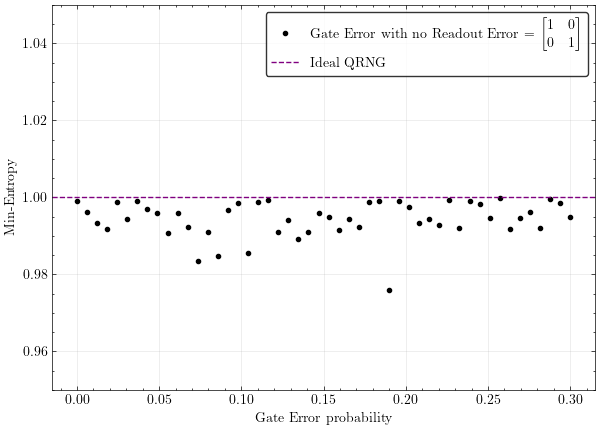

In [66]:
gate_probs = np.linspace(0, 0.3, 50)  # from 0% to 30%
entropies_gate = []

for p in gate_probs:
    noise_model = NoiseModel()
    gate_error = depolarizing_error(p, 1)
    noise_model.add_all_qubit_quantum_error(gate_error, ['h'])
    readout_error = ReadoutError([[1, 0], [0, 1]])  # measurement error set to zero 
    noise_model.add_all_qubit_readout_error(readout_error)

    backend_noisy = AerSimulator(noise_model=noise_model)
    result = backend_noisy.run(transpiled_qc, shots=50000, memory=True).result()
    bits = np.array(result.get_memory(), dtype=np.uint8)
    entropies_gate.append(min_entropy(bits))


plt.figure(figsize=(7,5))
plt.plot(gate_probs, entropies_gate, 'k.', linewidth=0.5, label=(r'Gate Error with no Readout Error = $\begin{bmatrix}1 & 0\\ 0 & 1\end{bmatrix}$'))
plt.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
plt.ylim(0.95, 1.05)
plt.xlabel('Gate Error probability')
plt.ylabel('Min-Entropy')
#plt.title('Effect of Gate Error on Min-Entropy (no Readout Error)')
plt.legend(frameon=True,             
    fancybox=True,                                     
    edgecolor='black',        
    facecolor='white',        
    fontsize=10              
    )
plt.grid(alpha=0.3)
plt.show()

$\Rightarrow$ seeing schematecally how *readout* errors affect the min-entropy value (with fixed and no gate errors) 

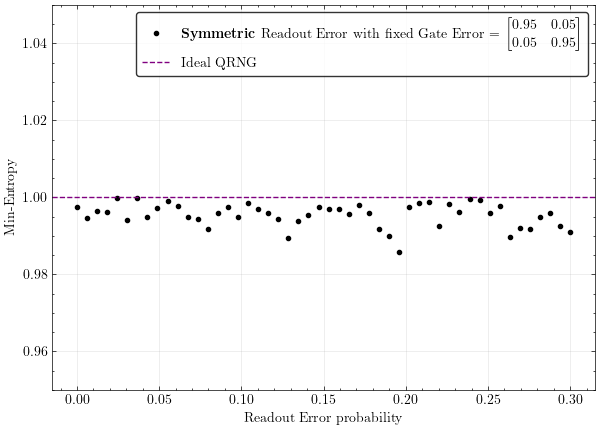

In [65]:
readout_probs = np.linspace(0, 0.3, 50)  # 0% to 30% flip probability in readout matrix
entropies_readout = []

for p in readout_probs:
    noise_model = NoiseModel()
    gate_error = depolarizing_error(0.05, 1)  # gate error fixed
    noise_model.add_all_qubit_quantum_error(gate_error, ['h'])

    ro_error = ReadoutError([[1-p, p],   # symmetric readout error model
                             [p, 1-p]])
    noise_model.add_all_qubit_readout_error(ro_error)

    backend_noisy = AerSimulator(noise_model=noise_model)
    result = backend_noisy.run(transpiled_qc, shots=50000, memory=True).result()
    bits = np.array(result.get_memory(), dtype=np.uint8)
    entropies_readout.append(min_entropy(bits))


plt.figure(figsize=(7,5))
plt.plot(readout_probs, entropies_readout, 'k.', label=(r'$\mathbf{Symmetric}$ Readout Error with fixed Gate Error = $\begin{bmatrix}0.95 & 0.05\\ 0.05 & 0.95\end{bmatrix}$'))
plt.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
plt.ylim(0.95, 1.05)
plt.xlabel('Readout Error probability')
plt.ylabel('Min-Entropy')
#plt.title('Effect of Readout Error on Min-Entropy (fixed Gate Error)')
plt.legend(frameon=True,             
    fancybox=True,                                     
    edgecolor='black',        
    facecolor='white',        
    fontsize=10
    )
plt.grid(alpha=0.3)
plt.show()

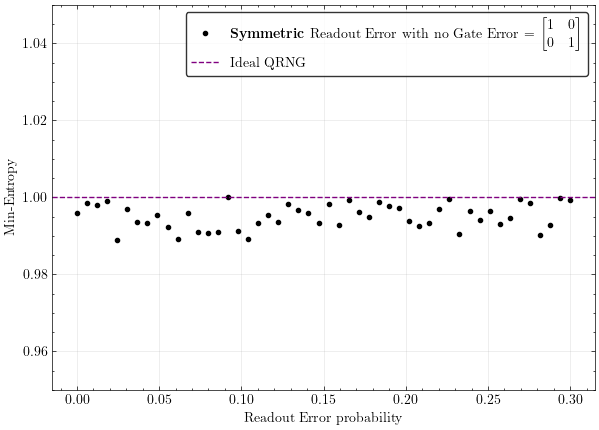

In [64]:
readout_probs = np.linspace(0, 0.3, 50)  # 0% to 30% flip probability in readout matrix
entropies_readout = []

for p in readout_probs:
    noise_model = NoiseModel()
    gate_error = depolarizing_error(0, 1)  # no gate error => perfect readout
    noise_model.add_all_qubit_quantum_error(gate_error, ['h'])

    ro_error = ReadoutError([[1-p, p],   # symmetric readout error model
                             [p, 1-p]])
    noise_model.add_all_qubit_readout_error(ro_error)

    backend_noisy = AerSimulator(noise_model=noise_model)
    result = backend_noisy.run(transpiled_qc, shots=50000, memory=True).result()
    bits = np.array(result.get_memory(), dtype=np.uint8)
    entropies_readout.append(min_entropy(bits))


plt.figure(figsize=(7,5))
plt.plot(readout_probs, entropies_readout, 'k.', label=(r' $\mathbf{Symmetric}$ Readout Error with no Gate Error = $\begin{bmatrix}1 & 0\\ 0 & 1\end{bmatrix}$'))
plt.axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
plt.ylim(0.95, 1.05)
plt.xlabel('Readout Error probability')
plt.ylabel('Min-Entropy')
#plt.title('Effect of Readout Error on Min-Entropy (no Gate Error)')
plt.legend(frameon=True,             
    fancybox=True,                                     
    edgecolor='black',        
    facecolor='white',        
    fontsize=10
    )
plt.grid(alpha=0.3)
plt.show()

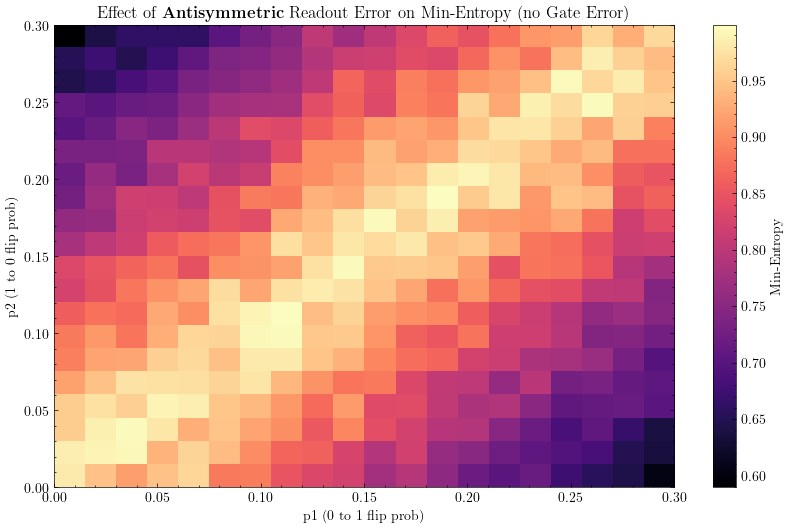

In [ ]:
p_vals = np.linspace(0, 0.3, 20) 
entropies = np.zeros((len(p_vals), len(p_vals)))

for i, p1 in enumerate(p_vals):
    for j, p2 in enumerate(p_vals):
        ro_error = ReadoutError([[1-p1, p1],
                                 [p2, 1-p2]])
        noise_model = NoiseModel()
        noise_model.add_all_qubit_readout_error(ro_error)

        backend_noisy = AerSimulator(noise_model=noise_model)
        result = backend_noisy.run(transpiled_qc, shots=5000).result()
        counts = result.get_counts()

        total = sum(counts.values())
        pmax = max(c / total for c in counts.values())
        entropies[i, j] = -np.log2(pmax)

plt.figure(figsize=(10, 6))
plt.imshow(entropies, origin='lower', 
           extent=[0, 0.3, 0, 0.3], aspect='auto', cmap='magma')
plt.colorbar(label='Min-Entropy')
plt.xlabel('p1 (0 to 1 flip prob)')
plt.ylabel('p2 (1 to 0 flip prob)')
plt.title(r'Effect of $\mathbf{Antisymmetric}$ Readout Error on Min-Entropy (no Gate Error)')
plt.show()

$\rightarrow$ heatmap shows how h-min changes due to readout errors that are antisymmetric (prob of reading 0 as 1 is different from reading 1 as 0)

$\rightarrow$ quantum gates are considered perfect in this simulation, thus only the readout (measurement) is noisy

$\rightarrow$ x-axis (p1): 0 to 1 flip prob : probability of incorrectly measuring a 0 as a 1 during readout

$\rightarrow$ y-axis (p2): 1 to 0 flip prob : probability of incorrectly measuring a 1 as a 0 during readout

- Purple (dark colors) = low h-min ~ 0.60

- Yellow (bright colors) = high h-min ~ 1.0

$\Rightarrow$ **bright diagonal band** = when p1 $\approx$ p2 = min-entropy is higher, even if both individual flip probabilities are significant, bc the readout errors partially *cancel each other out*

$\Rightarrow$ dark regions when p1 and p2 are very different 


#### **Symmetric vs Antisymmetric readout noise**

<div style="border: 2px solid gray; border-radius: 5px; padding: 10px; background-color: #f9f9f9; color: black;">


- **Symmetric** readout noise flips (0 to 1) and (1 to 0) with equal probability (p1 = p2).

    $\Rightarrow$ the overall balance of 0s and 1s does not change!!!

    $\Rightarrow$ min-entropy stays roughly **constant**

- **Antisymmetric** readout noise flips (0 to 1) and (1 to 0) with different probabilities (p1 != p2).

    $\Rightarrow$ the overall balance of 0s and 1s changes!!! 

    $\Rightarrow$ min-entropy **decreases** 

</div>

## CV QRNG

### Core Physics 

#### (1) Principle of CV QRNGs

CV QRNGs use **intrinsic quantum fluctuations** of a physical observable, typically the **quadratures of the electromagnetic field** in an optical mode. Unlike DV QRNGs (single-photon detection), CV QRNGs measure a **continuous distribution**

- Key idea: **Quantum vacuum noise** or **shot noise** provides a fundamentally random signal

- Observable: quadrature $ \hat{X} $ of a light field:  $\hat{X} = \frac{1}{2} (\hat{a} + \hat{a}^\dagger)$, where $\hat{a}$ and $\hat{a}^\dagger$ are the annihilation and creation operators

<div style="border: 2px solid gray; border-radius: 5px; padding: 10px; background-color: #f9f9f9; color: black;">
<b>So:</b> in quantum optics electromagnetic field can be described in terms of two 'quadratures' (X and P, aka position and momentum for harmonic oscillator)

$\rightarrow$ measuring a quadrature with a homodyne detector on the vacuum gives a *continuous random variable* distributed according to the quantum state

$\rightarrow$ for the vacuum state (ground state of the electromagnetic field mode), the outcome is Gaussian noise wavefunction centered at zero with variance set by the Heisenberg uncertainty principle

$\Rightarrow$ **randomness comes from *vacuum fluctuations* of the electromagnetic field**
even with nothing in the input port, when measuring quadratures quantum uncertainty ensures random outcomes!

thus, fundamental quantum origin of randomness (not biased technical noise)
</div>



#### (2) Quantum Noise Source

$|0\rangle$ (for a single optical mode) and $|0...0\rangle^{\otimes n}$ (for n optical modes) 
$\rightarrow$ Each mode gives independent Gaussian noise, so multi-mode just gives more independent samples


The **vacuum state** $|0\rangle$ exhibits zero-point fluctuations: $\langle \hat{X} \rangle = 0, \quad \Delta X = \sqrt{\langle \hat{X}^2 \rangle - \langle \hat{X} \rangle^2} = \frac{1}{2}$

- This variance $ \Delta X^2 $ represents **irreducible quantum uncertainty**.  
- Measuring the quadrature produces outcomes distributed according to a **Gaussian probability density function (PDF)**: $P(X) = \frac{1}{\sqrt{\pi}} e^{-X^2}$




#### (3) Measurement and Digitization

1. The optical signal is measured via **homodyne detection**:
   - Interference with a strong local oscillator converts the quadrature to a measurable voltage

2. The continuous outcome $ X $ is **sampled and digitized** to produce raw bits

- Typically, the voltage is split into bins to form discrete random numbers
- Raw distribution is **Gaussian**, not uniform. Post-processing or randomness extraction is needed for uniform bits



#### (4) Randomness Extraction

- To convert Gaussian-distributed raw data to uniform random bits:
  - **Von Neumann extraction**: removes bias in pairs of bits
  - **Hash functions / Trevisan extractors**: extract almost uniform bits from a high-entropy source

- Min-entropy is used to **quantify the worst-case unpredictability** of the raw measurement: $H_{\min} = -\log_2 \max_{x} P(x)$



#### 5. Advantages of CV QRNGs

- High-speed generation (GHz rates possible) because of **continuous measurement**
- Can leverage **standard photodiodes** — no single-photon detectors needed
- Fundamentally quantum: unpredictability guaranteed by **Heisenberg uncertainty principle**



<div style="border: 2px solid gray; border-radius: 5px; padding: 10px; background-color: #f9f9f9; color: black;">
<b> Note: <b> Qiskit’s standard qiskit library is qubit-based, not continuous-variable (CV) 

$\rightarrow$ cannot be used in this case
$\Rightarrow$ using qutip
</div>



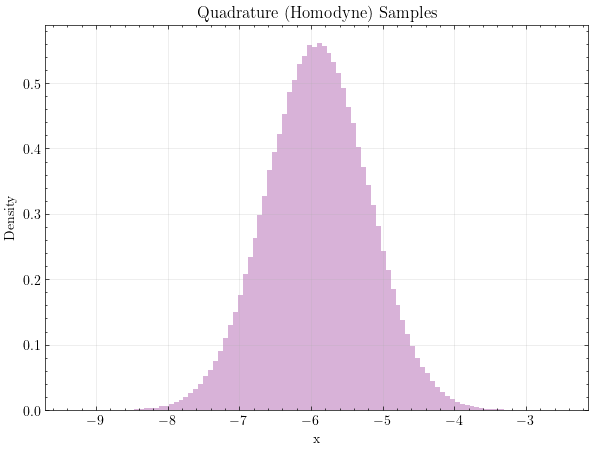

Min-entropy before extraction:  0.998785761898105  length:  1000000
Min-entropy after von Neumann extraction:  0.9963924909740755  length:  250433
First 100 von Neumann bits:  [1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1]


In [27]:
from qutip import coherent, squeeze, destroy, expect

shots = 1000000  # number of quadrature samples
alpha = 10.0  # displacement amplitude
r = 0.0  # squeezing parameter (0 = no squeeze)
theta = 0.0  # quadrature angle to measure (0 = x quadrature)

N = 50
a = destroy(N)  # annihilation operator
x_theta = (a * np.exp(-1j*theta) + a.dag() * np.exp(1j*theta)) / np.sqrt(2)

psi = coherent(N, alpha)  # start with coherent state
if r > 0:
    psi = squeeze(N, r) * psi  # optional squeezing

x_vals = np.linspace(-15, 15, 1000)  # grid for x
# Probability distribution P(x) = |<x|psi>|^2 via Qobj.wigner or numerical projection
# approximate using a Gaussian since coherent/squeezed states are Gaussian
mean = expect(x_theta, psi)
var = expect(x_theta**2, psi) - mean**2
samples = np.random.normal(mean, np.sqrt(var), shots)  # simulate homodyne

plt.figure(figsize=(7, 5))
plt.hist(samples, bins=100, density=True, alpha=0.3, color='purple')
plt.title('Quadrature (Homodyne) Samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.show()

# 2^8 = 256 => each bin can be represented as an 8-bit integer (ensuring Gaussian symmetry in terms of LSBs)
bins = np.linspace(min(samples), max(samples), 256)  # samples = continuous quadrature values (floats) from the Gaussian distribution
digitized = np.digitize(samples, bins) - 1  # each sample falls into which bin => each continuous quadrature value is now a discrete integer (1st bin => 1, 2nd bin => 2, etc)
raw_bits = (digitized & 1).astype(int)  # (digitized & 1) = bitwise AND with 1 => keeps only the least significant bit (LSB) of the integer, thus: each continuous quadrature sample is turned into one raw bit, depending on whether it falls in an even or odd bin

H_min = min_entropy(raw_bits)
print('Min-entropy before extraction: ', H_min, ' length: ', len(raw_bits))

vn_bits = von_neumann_extraction(raw_bits)
H_after = min_entropy(vn_bits)
print('Min-entropy after von Neumann extraction: ', H_after, ' length: ', len(vn_bits))
print('First 100 von Neumann bits: ', vn_bits[:100])


In [28]:
from ipywidgets import interact, FloatSlider

shots = 1000000  # number of quadrature samples
r = 0.0  # squeezing parameter
theta = 0.0  # quadrature angle
N = 50  # Hilbert space size

a = destroy(N)
x_theta = (a * np.exp(-1j*theta) + a.dag() * np.exp(1j*theta)) / np.sqrt(2)

def plot_hist(alpha):
    psi = coherent(N, alpha) 
    if r > 0:
        psi = squeeze(N, r) * psi

    mean = expect(x_theta, psi)
    var = expect(x_theta**2, psi) - mean**2
    samples = np.random.normal(mean, np.sqrt(var), shots)

    plt.figure(figsize=(7, 5))
    plt.grid(alpha=0.3)
    plt.hist(samples, bins=100, density=True, alpha=0.3, color='purple')
    plt.title(f'Quadrature (Homodyne) Samples,\n alpha (displacement amplitude of a coherent state) = {alpha}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.show()

interact(plot_hist, alpha=FloatSlider(value=0, min=-10, max=10, step=0.5))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=10.0, min=-10.0, step=0.5), Output()), _…

<function __main__.plot_hist(alpha)>

### *α* (alpha) in Coherent States

#### (1) Coherent State Basics

A **coherent state** $|\alpha\rangle$ is a quantum state of the electromagnetic field (or any harmonic oscillator) that is closest to a “classical” oscillating field. It is defined by the **complex number** $\alpha$: $|\alpha\rangle = e^{-|\alpha|^2/2} \sum_{n=0}^\infty \frac{\alpha^n}{\sqrt{n!}} |n\rangle$

- $|n\rangle$ are **Fock states** (energy eigenstates) 
- $\alpha = |\alpha| e^{i \phi}$ determines both **amplitude** and **phase**


#### (2) Quadrature Picture

A coherent state has a **Gaussian distribution** in the quadrature variables: $\hat{x} = \frac{a + a^\dagger}{\sqrt{2}}, \quad 
\hat{p} = \frac{a - a^\dagger}{i\sqrt{2}}$

- The **mean values** of the quadratures are:  $\langle \hat{x} \rangle = \sqrt{2} \, \text{Re}(\alpha), \quad 
\langle \hat{p} \rangle = \sqrt{2} \, \text{Im}(\alpha)$

- Variances are minimal:  $\text{Var}(\hat{x}) = \text{Var}(\hat{p}) = \frac{1}{2}$

So **α controls the center of the Gaussian** in the quadrature histogram:

- `alpha = 0` $\rightarrow$ centered at 0 (vacuum state)  
- `alpha > 0` $\rightarrow$ Gaussian shifted to the right  
- `alpha < 0` $\rightarrow$ Gaussian shifted to the left  


#### (3) Intuition

$|\alpha\rangle$ as a **classical oscillating field with amplitude $|\alpha|$ and phase $\arg(\alpha)$**:

- Increasing $|\alpha|$ $\rightarrow$ histogram **moves farther from zero** 
- Changing the **phase of α** (imaginary part) $\rightarrow$ rotates the Gaussian in the x-p plane



### Noise CV

$\Rightarrow$ adding homodyne detector noise $\rightarrow$ readout / measurement noise (symmetric and antisymmetric noise) 

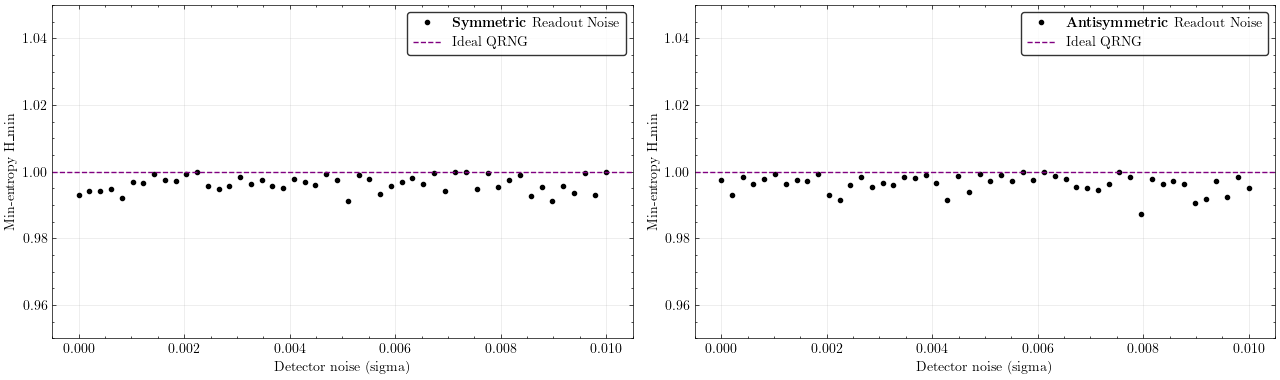

In [62]:
shots = 100000
samples = np.random.uniform(-1, 1, size=shots)
sigma_values = np.linspace(0, 0.01, 50)
H_symmetric_list = []
H_antisymmetric_list = []

# symmetric
for sigma_detector in sigma_values: # sigma_detector = represents how noisy the homodyne measurement is
    samples_noisy = samples + np.random.normal(0, sigma_detector, size=shots) # samples = ideal CV QRNG output (continuous values), adding generated Gaussian noise with mean=0 and standard deviation=sigma_detector
    bins_noisy = np.linspace(min(samples_noisy), max(samples_noisy), 256)
    digitized_noisy = np.digitize(samples_noisy, bins_noisy) - 1
    raw_bits_noisy = (digitized_noisy & 1).astype(int)
    H_symmetric_list.append(min_entropy(raw_bits_noisy))

# antisymmetric
for sigma_detector in sigma_values:
    bias_fluctuating = 0.10 + np.random.normal(0, 0.01, size=shots) # gaussian noise with a nonzero mean => shifted by 0.10
    asym_noise = np.random.normal(loc=bias_fluctuating, scale=sigma_detector, size=shots)
    samples_noisy = samples + asym_noise
    bins_noisy = np.linspace(min(samples_noisy), max(samples_noisy), 256)
    digitized_noisy = np.digitize(samples_noisy, bins_noisy) - 1
    raw_bits_noisy = (digitized_noisy & 1).astype(int)
    H_antisymmetric_list.append(min_entropy(raw_bits_noisy))

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(sigma_values, H_symmetric_list, 'k.', linewidth=0.5, label=r'$\mathbf{Symmetric}$ Readout Noise')
axes[0].axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
axes[0].set_ylim(0.95, 1.05)
axes[0].set_xlabel('Detector noise (sigma)')
axes[0].set_ylabel('Min-entropy H_min')
#axes[0].set_title('Effect of Symmetric Noise on Min-Entropy')
axes[0].grid(alpha=0.3)
axes[0].legend(frameon=True, fancybox=True, edgecolor='black', facecolor='white', fontsize=10)

axes[1].plot(sigma_values, H_antisymmetric_list, 'k.', label=r'$\mathbf{Antisymmetric}$ Readout Noise')
axes[1].axhline(1, color='purple', linestyle='--', label='Ideal QRNG')
axes[1].set_ylim(0.95, 1.05)
axes[1].set_xlabel('Detector noise (sigma)')
axes[1].set_ylabel('Min-entropy H_min')
#axes[1].set_title('Effect of Biased Noise on Min-Entropy')
axes[1].grid(alpha=0.3)
axes[1].legend(frameon=True, fancybox=True, edgecolor='black', facecolor='white', fontsize=10)

plt.tight_layout()
plt.show()

- Left plot: Symmetric noise / Unbiased: 
    - adds gaussian noise centered at 0 (unbiased, symmetric)

- Right plot: Antisymmetric / Biased:
    - adds gaussian noise with a nonzero mean (0.10 + small fluctuation)